# Get USGS Gage Numbers from Site Numbers and filter the geodataframe
* Filtering is done based on Gages II reference gages
* Filtering is done based on active USGS gages (when NHDplusV21 was published)

* First used a HADS file location to figure out site numbers - not sufficient so then installed and used dataretrival. Verfieid they got the same number which is good

In [4]:
import geopandas as gpd
import pandas as pd
import dataretrieval.nwis as nwis
from tqdm import tqdm  # optional: progress bar

In [1]:
# Load your .gpkg - Segmented NHD Plus segments to where there is a NHD plus "gage"
gpkg_file  = "/Users/wcurrier/Downloads/NHDPlusv21_gages_inAQPI_w_COMID4NWM.gpkg"
gdf = gpd.read_file(gpkg_file)

# Filter to only active sites
gdf_active = gdf[gdf["Active"] == '1'].copy()

# Load HADS sites - Maps Name to USGS Site Number and the NWS ID
# NWS ID can be used to pull CNRFC data
# USGS Site Number can be used to pull observations
# HADS = Hydrometerological Automated Data System
hads_file = "https://hads.ncep.noaa.gov/USGS/ALL_USGS-HADS_SITES.txt"
df_hads = pd.read_fwf(
    hads_file, 
    skiprows=3,
    names=["NWS_ID","USGS_Site","GOES","NWS_HSA","LAT","LON","NAME"],
    widths=[6,15,10,5,11,12,100]
)

# Clean NAME: strip leading "|" and whitespace
df_hads["NAME_CLEAN"] = df_hads["NAME"].str.strip().str.lstrip("|")
# Clean NWS_ID: remove trailing '|'
df_hads["NWS_ID_CLEAN"] = df_hads["NWS_ID"].astype(str).str.rstrip("|").str.strip()

# Lookup function returning both USGS_Site and cleaned NWS_ID from the HAS_SITES.TXT
def get_usgs_info(station_name, hads_df):
    match = hads_df.loc[hads_df["NAME_CLEAN"] == station_name]
    if not match.empty:
        return pd.Series({
            "USGS_Site": match["USGS_Site"].iloc[0],
            "NWS_ID": match["NWS_ID_CLEAN"].iloc[0]
        })
    else:
        return pd.Series({"USGS_Site": None, "NWS_ID": None})

# Apply lookup for each station
gdf_active[["USGS_Site", "NWS_ID"]] = gdf_active["STATION_NM"].apply(lambda x: get_usgs_info(x, df_hads))

# Check results
print(gdf_active[["STATION_NM", "USGS_Site", "NWS_ID"]].head())

/Users/wcurrier/miniconda3/envs/py3/lib/python3.6/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


                                STATION_NM USGS_Site NWS_ID
0                  DAGGETT CK NR GENOA, NV      None   None
2   LEVIATHAN C AB MINE NR MARKLEEVILLE CA  10308783  LVCC1
7             INDEPENDENCE C NR TRUCKEE CA  10343000  ICRC1
8                 WALKER RV NR WABUSKA, NV      None   None
11            W WALKER RV NR COLEVILLE, CA      None   None


In [6]:
# Further subset based on whether it is a reference gage
gdf_ref = gdf_active[gdf_active["GagesII"] == 'Ref'].reset_index().copy()
print(gdf_ref[["STATION_NM", "USGS_Site", "NWS_ID"]].head()) # still missing some USGS Gage Numbers


                                          STATION_NM USGS_Site NWS_ID
0             LEVIATHAN C AB MINE NR MARKLEEVILLE CA  10308783  LVCC1
1                 WARD C AT HWY 89 NR TAHOE PINES CA  10336676  WDKC1
2  E FK CARSON RV BLW MARKLEEVILLE CK NR MARKLEEV...  10308200  CEMC1
3                       BUCKEYE CK NR BRIDGEPORT, CA      None   None
4                            SAGEHEN C NR TRUCKEE CA  10343500  SGNC1


In [7]:
# still Missing some USGS Gage Numbers - find another way to get the Gage Number
def fetch_usgs_site_number(name, state):
    """
    Query NWIS for a site number given a station name and state.
    Returns the first match or None if no match is found.
    """
    try:
        sites, meta = nwis.what_sites(stateCd=state, siteName=name)
        if not sites.empty:
            return sites.iloc[0]['site_no']  # first matching site
        else:
            return None
    except Exception as e:
        # If there is an API error or no data, return None
        return None

# Apply row by row
tqdm.pandas()  # enables progress_apply for a nice progress bar
gdf_ref['USGS_STATION_NUMBER'] = gdf_ref.progress_apply(
    lambda row: fetch_usgs_site_number(row['STATION_NM'], row['STATE']),
    axis=1
)

100%|██████████| 48/48 [00:09<00:00,  5.08it/s]


In [15]:
from dataretrieval import nwis

site_numbers = ["09180500", "10308783"]  # example valid USGS site numbers
start = "2020-01-01"
end   = "2023-12-31"

for sn in site_numbers:
    df, meta = nwis.get_dv(sites=sn, parameterCd="00060", start=start, end=end)
    print(f"{sn} rows: {len(df)}")
    print(df.head())

09180500 rows: 1461
                           00060_Mean 00060_Mean_cd   site_no
datetime                                                     
2020-01-01 00:00:00+00:00      3670.0          A, e  09180500
2020-01-02 00:00:00+00:00      3500.0          A, e  09180500
2020-01-03 00:00:00+00:00      3420.0          A, e  09180500
2020-01-04 00:00:00+00:00      3380.0          A, e  09180500
2020-01-05 00:00:00+00:00      3330.0          A, e  09180500
10308783 rows: 1461
                           00060_Mean 00060_Mean_cd   site_no
datetime                                                     
2020-01-01 00:00:00+00:00        0.13             A  10308783
2020-01-02 00:00:00+00:00        0.12             A  10308783
2020-01-03 00:00:00+00:00        0.12             A  10308783
2020-01-04 00:00:00+00:00        0.15             A  10308783
2020-01-05 00:00:00+00:00        0.16             A  10308783


# Get Observed Streamflow Data from the USGS
* Get the hourly USGS streamflow values now that we have the USGS gage number

In [17]:
import pandas as pd
from dataretrieval import nwis
from tqdm import tqdm

def get_usgs_streamflow(site, start, end, paramCd="00060"):
    """
    Try hourly -> 15 min -> daily for a USGS site.
    Returns (DataFrame, frequency_string)
    """
    # 1️⃣ Try IV (instantaneous) - hourly
    try:
        df_hr, meta = nwis.get_iv(sites=site, start=start, end=end, parameterCd=paramCd)
        if not df_hr.empty:
            df_hr = df_hr.resample("H").mean()
            return df_hr, "hourly"
    except:
        pass

    # 2️⃣ Try IV (instantaneous) - 15-min
    try:
        df_15, meta = nwis.get_iv(sites=site, start=start, end=end, parameterCd=paramCd)
        if not df_15.empty:
            df_15 = df_15.resample("H").mean()
            return df_15, "15min->hourly"
    except:
        pass

    # 3️⃣ Fallback to DV (daily)
    try:
        df_dv, meta = nwis.get_dv(sites=site, start=start, end=end, parameterCd=paramCd, statCd="00003")
        if not df_dv.empty:
            return df_dv, "daily"
    except:
        pass

    return pd.DataFrame(), "no data"

# -----------------------
# Loop over GeoDataFrame
# -----------------------
all_data = {}
frequencies = []

for site in tqdm(gdf_ref['USGS_STATION_NUMBER'], desc="Downloading sites"):
    df, freq = get_usgs_streamflow(site, start="2025-09-01", end="2025-09-18")
    all_data[site] = df
    frequencies.append(freq)

# Add frequency column to gdf_ref
gdf_ref['frequency'] = frequencies

# gdf_ref now shows which sites used hourly, 15-min->hourly, daily, or no data
print(gdf_ref[['STATION_NM','USGS_STATION_NUMBER','frequency']].head())

# -------------------
# Step 4: Save results
# -------------------

# summary_df.to_csv("gage_download_summary.csv", index=False)

# Combine to xarray if wanted
# if all_data:
#     combined = pd.concat(all_data.values(), axis=1)
#     combined.to_csv("discharge_timeseries.csv")
    # or: combined.to_xarray().to_netcdf("discharge_timeseries.nc")

                                          STATION_NM USGS_STATION_NUMBER  \
0             LEVIATHAN C AB MINE NR MARKLEEVILLE CA            10308783   
1                 WARD C AT HWY 89 NR TAHOE PINES CA            10336676   
2  E FK CARSON RV BLW MARKLEEVILLE CK NR MARKLEEV...            10308200   
3                       BUCKEYE CK NR BRIDGEPORT, CA            10291500   
4                            SAGEHEN C NR TRUCKEE CA            10343500   

  frequency  
0    hourly  
1    hourly  
2    hourly  
3    hourly  
4    hourly  


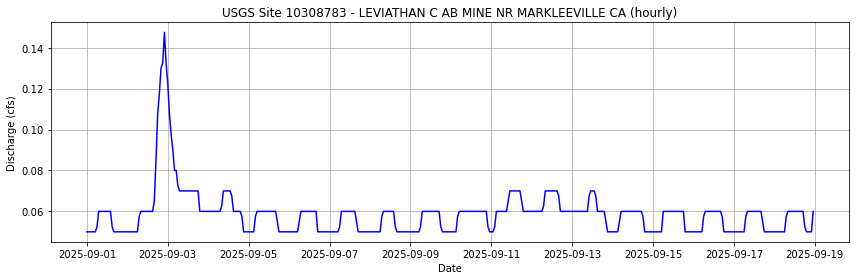

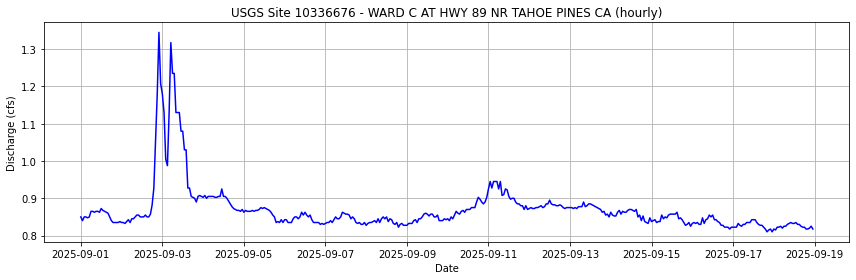

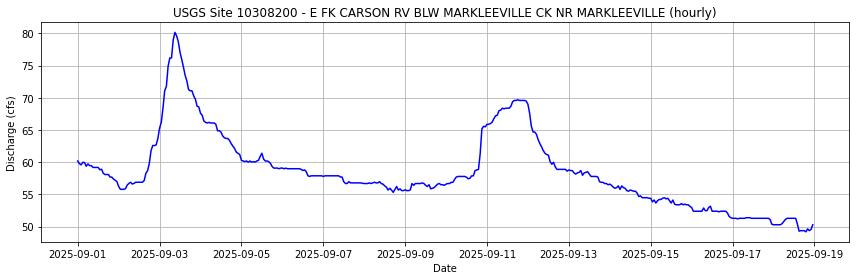

In [26]:
import matplotlib.pyplot as plt

def plot_usgs_sites(all_data, gdf_ref, sites_to_plot):
    """
    Plot time series of USGS discharge for selected sites.
    
    Parameters:
        all_data : dict
            Dictionary of site_no -> DataFrame
        gdf_ref : GeoDataFrame
            Contains 'USGS_STATION_NUMBER', 'STATION_NM', and 'frequency'
        sites_to_plot : list
            List of site_no strings to plot
    """
    for site in sites_to_plot:
        df = all_data.get(site)
        if df is None or df.empty:
            print(f"No data for site {site}")
            continue
        
        # Lookup station name and frequency
        row = gdf_ref[gdf_ref['USGS_STATION_NUMBER'] == site].iloc[0]
        station_name = row['STATION_NM']
        frequency = row['frequency']
        
        # Plot
        plt.figure(figsize=(12, 4))
        plt.plot(df.index, df.iloc[:, 0], color='blue')
        plt.xlabel("Date")
        plt.ylabel("Discharge (cfs)")
        plt.title(f"USGS Site {site} - {station_name} ({frequency})")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# Example usage - pick a couple of sites
sites_to_plot = [gdf_ref['USGS_STATION_NUMBER'][0], gdf_ref['USGS_STATION_NUMBER'][1],gdf_ref['USGS_STATION_NUMBER'][2]]
plot_usgs_sites(all_data, gdf_ref, sites_to_plot)

# Get RFC Forecast data
* I would plot the RFC data over the NWM data
* Note that the RFC "observations" are still simulations and not USGS obs according to their website (likely uses USGS obs)

In [38]:
import pandas as pd
import requests
import geopandas as gpd
import matplotlib.pyplot as plt
from dateutil.parser import parse

# -------------------
# Function to fetch RFC data
# -------------------
def get_rfc_data(site_id):
    """
    Fetch RFC observed and forecast data for a given NWS_ID (RFC site).

    Returns:
        df_obs: DataFrame of observed data
        df_forecast: DataFrame of forecast data
    """
    url = f"https://www.cnrfc.noaa.gov/graphicalRVF_tabular.php?id={site_id}"
    try:
        r = requests.get(url)
        lines = r.text.splitlines()
        if "# FORECAST" not in r.text:
            return None, None  # no forecast data available

        # Locate OBSERVED and FORECAST sections
        obs_start = next(i for i, l in enumerate(lines) if l.strip() == "# OBSERVED") + 2
        fore_start = next(i for i, l in enumerate(lines) if l.strip() == "# FORECAST") + 2
        obs_end = fore_start - 2

        # Extract lines, ignoring comments/blanks
        obs_lines = [l for l in lines[obs_start:obs_end] if l.strip() and not l.startswith("#")]
        forecast_lines = [l for l in lines[fore_start:] if l.strip() and not l.startswith("#")]

        cols = ["Date_Time", "Stage_ft", "Flow_cfs", "Trend", "Status"]

        # Helper function to parse a line
        def parse_line(line):
            parts = line.split()
            if len(parts) < 6:
                return None
            try:
                dt_str = " ".join(parts[:4])
                dt = parse(dt_str)  # handles timezone abbreviations
                stage = float(parts[4])
                flow = float(parts[5])
                trend = parts[6] if len(parts) > 6 else None
                status = parts[7] if len(parts) > 7 else None
                return [dt, stage, flow, trend, status]
            except Exception:
                return None

        # Parse observed
        obs_data = [parse_line(l) for l in obs_lines]
        obs_data = [d for d in obs_data if d is not None]
        df_obs = pd.DataFrame(obs_data, columns=cols).set_index("Date_Time")

        # Parse forecast
        fc_data = [parse_line(l) for l in forecast_lines]
        fc_data = [d for d in fc_data if d is not None]
        df_forecast = pd.DataFrame(fc_data, columns=cols).set_index("Date_Time")

        return df_obs, df_forecast

    except Exception as e:
        print(f"Error fetching {site_id}: {e}")
        return None, None

# -------------------
# Loop through RFC sites in gdf_ref
# -------------------
rfc_data = {}
gdf_ref["RFC_available"] = False  # initialize column

for idx, row in gdf_ref.iterrows():
    nws_id = row.get("NWS_ID")
    if nws_id and nws_id != "None":
        df_obs, df_fc = get_rfc_data(nws_id)
        if df_obs is not None and not df_obs.empty and df_fc is not None and not df_fc.empty:
            rfc_data[nws_id] = {"observed": df_obs, "forecast": df_fc}
            gdf_ref.at[idx, "RFC_available"] = True



/Users/wcurrier/miniconda3/envs/py3/lib/python3.6/site-packages/dateutil/parser/_parser.py:1212: UnknownTimezoneWarning: tzname PDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


#### Using the active refence USGS gage sites based on NHDplusv21 and gageII information we have the following gages
#### not all of them are RFC forecast points

(35.0, 41.0)

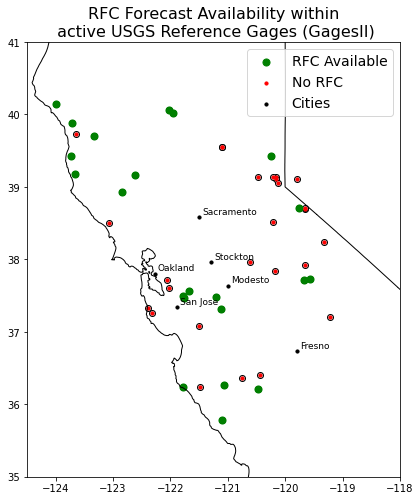

In [52]:
import geopandas as gpd
from shapely.geometry import Point

# -------------------
# Map RFC availability with state lines and major cities
# -------------------
fig, ax = plt.subplots(figsize=(12, 8))

# Plot RFC site availability
gdf_ref.plot(ax=ax, color="lightgrey", edgecolor="k")
gdf_ref[gdf_ref["RFC_available"]].plot(ax=ax, color="green", label="RFC Available",markersize=50)
gdf_ref[~gdf_ref["RFC_available"]].plot(ax=ax, color="red", label="No RFC",markersize=10)

# Add California state lines (and optionally neighboring states)
# Load the state boundaries shapefile
states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_5m.json'
states_gdf = gpd.read_file(states_url)
california=states_gdf[states_gdf['NAME']=='California']
california.boundary.plot(ax=ax, color="black", linewidth=1)

# Add major Bay Area + Central Valley cities
cities_data = [
    {"city": "Oakland", "lat": 37.8044, "lon": -122.2712},
    {"city": "San Jose", "lat": 37.3382, "lon": -121.8863},
    {"city": "Sacramento", "lat": 38.5816, "lon": -121.4944},
    {"city": "Fresno", "lat": 36.7378, "lon": -119.7871},
    {"city": "Modesto", "lat": 37.6391, "lon": -120.9969},
    {"city": "Stockton", "lat": 37.9577, "lon": -121.2908}
]
#     {"city": "San Francisco", "lat": 37.7749, "lon": -122.4194},

cities_gdf = gpd.GeoDataFrame(
    cities_data, 
    geometry=[Point(xy["lon"], xy["lat"]) for xy in cities_data],
    crs="EPSG:4326"
)

cities_gdf.plot(ax=ax, color="black", markersize=10, label="Cities")

# Annotate city names
for idx, row in cities_gdf.iterrows():
    ax.annotate(row["city"], xy=(row.geometry.x, row.geometry.y),
                xytext=(3, 3), textcoords="offset points", fontsize=9)

plt.legend(fontsize=14)
plt.title("RFC Forecast Availability within\n active USGS Reference Gages (GagesII)",fontsize=16)
plt.xlim([-124.5,-118])
plt.ylim([35,41])


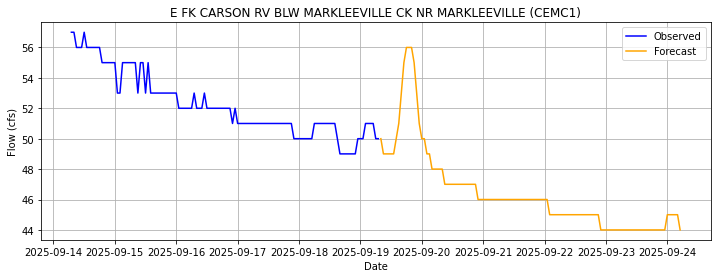

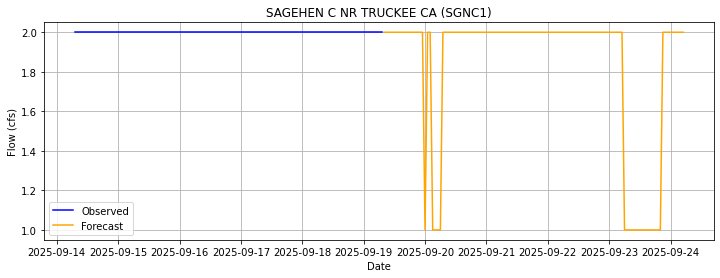

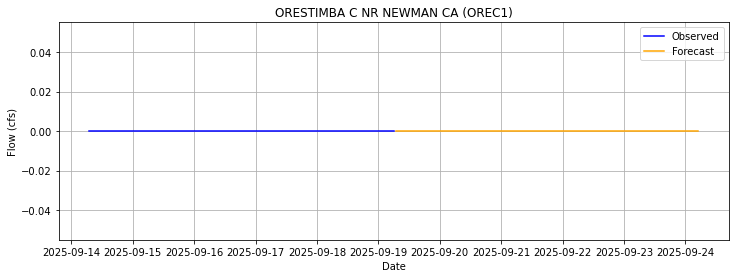

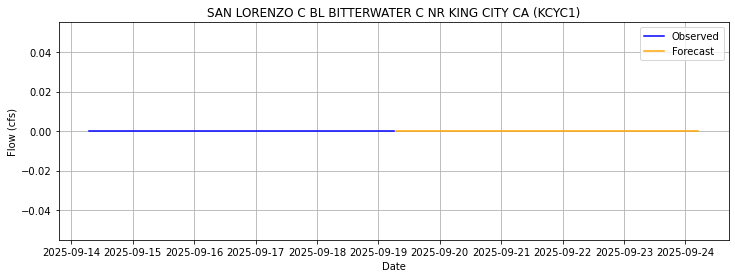

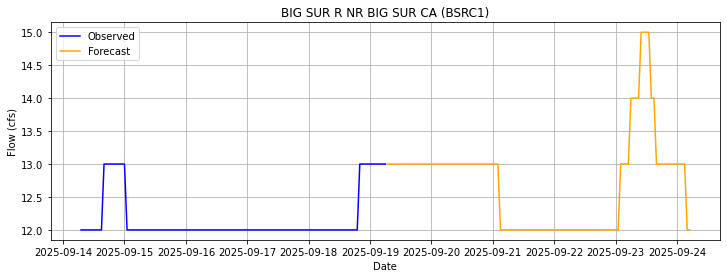

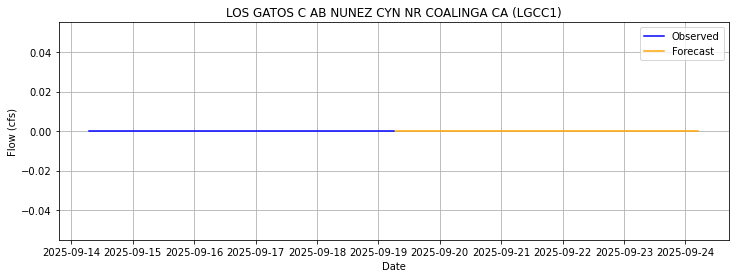

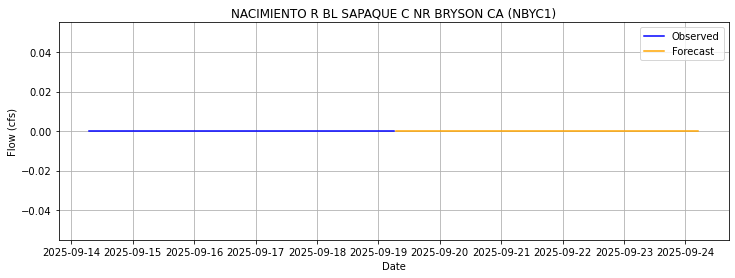

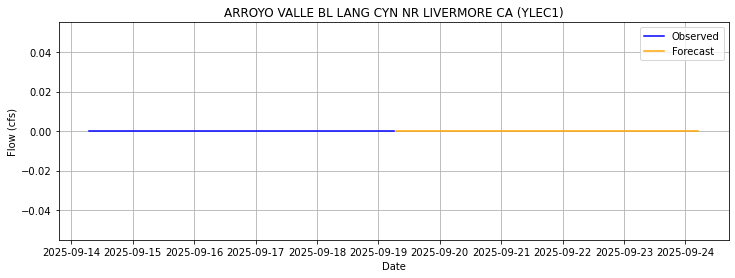

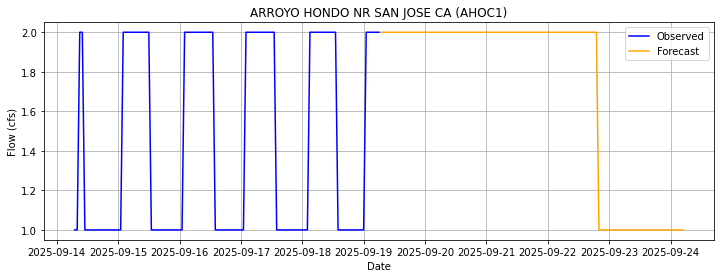

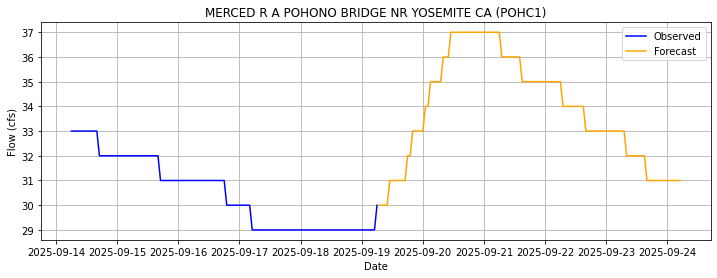

In [54]:
# -------------------
# Plot observed vs forecast for selected sites
# -------------------
def plot_rfc_timeseries(rfc_data, gdf_ref, sites_to_plot):
    for nws_id in sites_to_plot:
        if nws_id not in rfc_data:
            print(f"No RFC data for {nws_id}")
            continue
        df_obs = rfc_data[nws_id]["observed"]
        df_fc = rfc_data[nws_id]["forecast"]
        station_name = gdf_ref.loc[gdf_ref["NWS_ID"] == nws_id, "STATION_NM"].values[0]

        plt.figure(figsize=(12, 4))
        plt.plot(df_obs.index, df_obs["Flow_cfs"], label="Observed", color="blue")
        plt.plot(df_fc.index, df_fc["Flow_cfs"], label="Forecast", color="orange")
        plt.xlabel("Date")
        plt.ylabel("Flow (cfs)")
        plt.title(f"{station_name} ({nws_id})")
        plt.legend()
        plt.grid(True)
        plt.show()

# Example: plot first 10 available sites
sites_to_plot = list(rfc_data.keys())[:10]
plot_rfc_timeseries(rfc_data, gdf_ref, sites_to_plot)


In [57]:
rfc_data.keys()

dict_keys(['CEMC1', 'SGNC1', 'OREC1', 'KCYC1', 'BSRC1', 'LGCC1', 'NBYC1', 'YLEC1', 'AHOC1', 'POHC1', 'PTTC1', 'MPTC1', 'NVRC1', 'KCVC1', 'LEGC1', 'HPIC1', 'HOUC1', 'MLMC1', 'FTBC1', 'DCVC1', 'ETTC1', 'DOSC1'])

# Get CNRFC forecast locations from xml file
* Appears some locations are missing - the RFC forecasts more than these points

pull in all CNRFC forecast points

In [55]:
import pandas as pd
import xml.etree.ElementTree as ET
import requests

# Download the XML
url = "https://www.cnrfc.noaa.gov/data/kml/riverFcst.xml?random=0.5834993435787819"
response = requests.get(url)
xml_content = response.content

# Parse XML
root = ET.fromstring(xml_content)

# Extract all riverFcst entries
data = []
for river in root.findall('riverFcst'):
    data.append(river.attrib)

# Convert to DataFrame
df = pd.DataFrame(data)

# Optional: convert numeric columns
numeric_cols = ['latitude','longitude','printLat','printLon','printElev']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

print(df.head())

  amount         riverName                 stationName    typePt  latitude  \
0  green       Smith River   Jedediah Smith SP (CREC1)  Forecast  41.78944   
1  green       Smith River  Doctor Fine Bridge (FTDC1)  Forecast  41.88083   
2  green     Sprague River              Beatty (BTYO3)  Forecast  42.44722   
3  green  Williamson River           Chiloquin (WMSO3)  Forecast  42.56500   
4  green       Scott River          Fort Jones (FTJC1)  Forecast  41.64083   

   longitude  printLat  printLon  printElev  \
0 -124.05389     41.79    124.05        110   
1 -124.13528     41.88    124.14          0   
2 -121.23750     42.45    121.24       4305   
3 -121.87833     42.56    121.88       4148   
4 -123.01389     41.64    123.01       2624   

                                           printCrit           fcstDate  \
0  Action|Monitor: 25.0 / Minor Flood: 29.0 / Mod...  09/19 at 1342 UTC   
1  Action|Monitor: 27.0 / Minor Flood: 33.0 / Mod...  09/19 at 1342 UTC   
2  Action|Monitor: 7.5 

In [58]:
# # Example: rfc_data.keys() contains all possible RFC site IDs
# rfc_keys = set(rfc_data.keys())
# df_ids = set(df['id'])

# missing_ids = rfc_keys - df_ids
# print("Missing RFC IDs:", missing_ids)

Missing RFC IDs: set()


In [72]:
# Create a GeoDataFrame from your XML DataFrame:
import geopandas as gpd
from shapely.geometry import Point
from fastkml import kml
from shapely.ops import unary_union

gdf_rfc = gpd.GeoDataFrame(
    df,
    geometry=[Point(xy) for xy in zip(df['longitude'], df['latitude'])],
    crs="EPSG:4326"
) # make the dataframe from the xml file we pulled in a geodataframe - then subset based on AQPI domain

# Load in KML file to get Lat Lon Bounds of AQPI domain
# In case you don't have these packages:

# Reuslts:

#Bounds:
#Min Latitude: 35.61787120861296
#Max Latitude: 40.2028753676532
#Min Longitude: -125.5904643983031
#Max Longitude: -119.0914300520682
aqpi_bounds_kml_file='/Users/wcurrier/Downloads/Atmospheric Model.kml'
with open(aqpi_bounds_kml_file, "r") as f:
    kml_data = f.read()

k = kml.KML()
k.from_string(kml_data.encode('utf-8'))

features = list(k.features())
sub_features = list(features[0].features())
geoms = [f.geometry for f in sub_features]

unioned = unary_union(geoms)
minx, miny, maxx, maxy = unioned.bounds
print(f"Bounds:\nMin Latitude: {miny}\nMax Latitude: {maxy}\nMin Longitude: {minx}\nMax Longitude: {maxx}")
gdf_rfc=gdf_rfc.cx[minx:maxx, miny:maxy] #Subset RFC sites to AQPI domain
gdf_rfc

Bounds:
Min Latitude: 35.61787120861296
Max Latitude: 40.2028753676532
Min Longitude: -125.5904643983031
Max Longitude: -119.0914300520682


,amount,riverName,stationName,typePt,latitude,longitude,printLat,printLon,printElev,printCrit,fcstDate,fcstFeetFlow,obsFeetFlow,id,idLow,geometry
13,green,South Fork Eel River,Miranda (MRNC1),Forecast,40.18222,-123.77500,40.18,123.78,218,Action|Monitor: 27.0 / Minor Flood: 33.0 / Mod...,09/19 at 1342 UTC,5.66 Ft / 27 cfs,5.66 Ft / 28 cfs,MRNC1,mrnc1,POINT (-123.77500 40.18222)
23,white,Mattole River,Ettersburg (ETTC1),Other,40.13945,-123.99028,40.14,123.99,579,,09/19 at 1342 UTC,8.40 Ft / 7 cfs,8.40 Ft / 7 cfs,ETTC1,ettc1,POINT (-123.99028 40.13945)
28,white,Middle Fork Eeel River,Dos Rios (DOSC1),Other,39.70639,-123.32417,39.71,123.32,902,,09/19 at 1342 UTC,3.18 Ft / 22 cfs,3.17 Ft / 22 cfs,DOSC1,dosc1,POINT (-123.32417 39.70639)
29,white,South Fork Eel River,Leggett (LEGC1),Other,39.87472,-123.71944,39.87,123.72,700,,09/19 at 1342 UTC,4.62 Ft / 17 cfs,4.64 Ft / 19 cfs,LEGC1,legc1,POINT (-123.71944 39.87472)
33,white,Noyo River,Fort Bragg (FTBC1),Other,39.42833,-123.73667,39.43,123.74,12,,09/19 at 1342 UTC,2.43 Ft / 5 cfs,2.42 Ft / 4 cfs,FTBC1,ftbc1,POINT (-123.73667 39.42833)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258,white,Eastside Bypass,El Nido (ELNC1),Other,37.13306,-120.56694,37.13,120.57,90,,09/19 at 1353 UTC,11.91 Ft / 1 cfs,8.80 Ft / 0 cfs,ELNC1,elnc1,POINT (-120.56694 37.13306)
259,white,Chowchilla Bypass,Ripperdan (CHBC1),Other,36.77417,-120.28528,36.77,120.29,170,,09/19 at 1353 UTC,163.60 Ft / 30 cfs,163.05 Ft / 0 cfs,CHBC1,chbc1,POINT (-120.28528 36.77417)
260,white,San Joaquin River,Mendota (SJMC1),Other,36.81056,-120.37823,36.81,120.38,152,,09/19 at 1353 UTC,3.41 Ft / 291 cfs,3.42 Ft / 293 cfs,SJMC1,sjmc1,POINT (-120.37823 36.81056)
261,white,James Bypass,San Joaquin (JAMC1),Other,36.65250,-120.18028,36.65,120.18,170,,09/19 at 1353 UTC,7.60 Ft / 0 cfs,5.77 Ft / 0 cfs,JAMC1,jamc1,POINT (-120.18028 36.65250)


In [63]:
gdf_ref['RFC_available_2'] = gdf_ref['NWS_ID'].isin(df_ids)


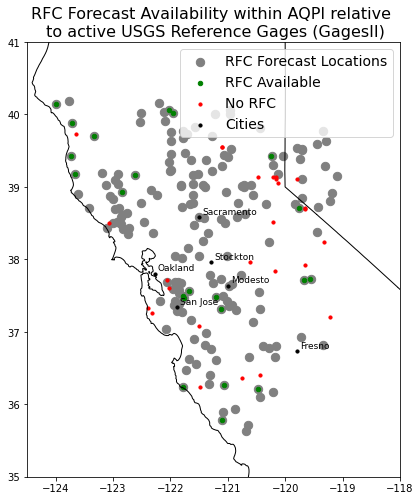

In [75]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 8))

# Plot RFC site availability
gdf_rfc.plot(ax=ax, color="gray", label="RFC Forecast Locations", markersize=70)

# gdf_ref.plot(ax=ax, color="lightgrey", edgecolor="k")
gdf_ref[gdf_ref["RFC_available_2"]].plot(ax=ax, color="green", label="RFC Available", markersize=20)
gdf_ref[~gdf_ref["RFC_available_2"]].plot(ax=ax, color="red", label="No RFC", markersize=10)

# California state lines
states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_5m.json'
states_gdf = gpd.read_file(states_url)
california = states_gdf[states_gdf['NAME']=='California']
california.boundary.plot(ax=ax, color="black", linewidth=1)

# Cities
from shapely.geometry import Point

cities_data = [
    {"city": "Oakland", "lat": 37.8044, "lon": -122.2712},
    {"city": "San Jose", "lat": 37.3382, "lon": -121.8863},
    {"city": "Sacramento", "lat": 38.5816, "lon": -121.4944},
    {"city": "Fresno", "lat": 36.7378, "lon": -119.7871},
    {"city": "Modesto", "lat": 37.6391, "lon": -120.9969},
    {"city": "Stockton", "lat": 37.9577, "lon": -121.2908}
]

cities_gdf = gpd.GeoDataFrame(
    cities_data, 
    geometry=[Point(xy["lon"], xy["lat"]) for xy in cities_data],
    crs="EPSG:4326"
)

cities_gdf.plot(ax=ax, color="black", markersize=10, label="Cities")

# Annotate city names
for idx, row in cities_gdf.iterrows():
    ax.annotate(row["city"], xy=(row.geometry.x, row.geometry.y),
                xytext=(3, 3), textcoords="offset points", fontsize=9)

plt.legend(fontsize=14)
plt.title("RFC Forecast Availability within AQPI relative \n to active USGS Reference Gages (GagesII)", fontsize=16)
plt.xlim([-124.5,-118])
plt.ylim([35,41])
plt.show()

### That's a lot of forecast locations - lets get those and store that seperately.
* 170 RFC locations in the AQPI domain

In [77]:
# -------------------
# Loop through all RFC sites within AQPI domain and get the RFC forecasts
# -------------------
rfc_data_all = {}

for idx, row in gdf_rfc.iterrows():
    nws_id = row.get("id")
    if nws_id and nws_id != "None":
        df_obs, df_fc = get_rfc_data(nws_id)
        if df_obs is not None and not df_obs.empty and df_fc is not None and not df_fc.empty:
            rfc_data_all[nws_id] = {"observed": df_obs, "forecast": df_fc}

/Users/wcurrier/miniconda3/envs/py3/lib/python3.6/site-packages/dateutil/parser/_parser.py:1212: UnknownTimezoneWarning: tzname PDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


In [80]:
rfc_data_all['MRNC1']['observed']

,Stage_ft,Flow_cfs,Trend,Status
Date_Time,,,,
2025-09-14 06:00:00,5.70,33.0,<font,color='#00FF00'>
2025-09-14 07:00:00,5.70,33.0,0<font,color='#00FF00'>
2025-09-14 08:00:00,5.70,33.0,0<font,color='#00FF00'>
2025-09-14 09:00:00,5.70,33.0,0<font,color='#00FF00'>
2025-09-14 10:00:00,5.70,33.0,0<font,color='#00FF00'>
...,...,...,...,...
2025-09-19 02:00:00,5.66,28.0,0<font,color='#00FF00'>
2025-09-19 03:00:00,5.65,26.0,-<font,color='#00FF00'>
2025-09-19 04:00:00,5.65,26.0,0<font,color='#00FF00'>


In [82]:
len(rfc_data_all.keys())

170

In [84]:
gdf_rfc

,amount,riverName,stationName,typePt,latitude,longitude,printLat,printLon,printElev,printCrit,fcstDate,fcstFeetFlow,obsFeetFlow,id,idLow,geometry
13,green,South Fork Eel River,Miranda (MRNC1),Forecast,40.18222,-123.77500,40.18,123.78,218,Action|Monitor: 27.0 / Minor Flood: 33.0 / Mod...,09/19 at 1342 UTC,5.66 Ft / 27 cfs,5.66 Ft / 28 cfs,MRNC1,mrnc1,POINT (-123.77500 40.18222)
23,white,Mattole River,Ettersburg (ETTC1),Other,40.13945,-123.99028,40.14,123.99,579,,09/19 at 1342 UTC,8.40 Ft / 7 cfs,8.40 Ft / 7 cfs,ETTC1,ettc1,POINT (-123.99028 40.13945)
28,white,Middle Fork Eeel River,Dos Rios (DOSC1),Other,39.70639,-123.32417,39.71,123.32,902,,09/19 at 1342 UTC,3.18 Ft / 22 cfs,3.17 Ft / 22 cfs,DOSC1,dosc1,POINT (-123.32417 39.70639)
29,white,South Fork Eel River,Leggett (LEGC1),Other,39.87472,-123.71944,39.87,123.72,700,,09/19 at 1342 UTC,4.62 Ft / 17 cfs,4.64 Ft / 19 cfs,LEGC1,legc1,POINT (-123.71944 39.87472)
33,white,Noyo River,Fort Bragg (FTBC1),Other,39.42833,-123.73667,39.43,123.74,12,,09/19 at 1342 UTC,2.43 Ft / 5 cfs,2.42 Ft / 4 cfs,FTBC1,ftbc1,POINT (-123.73667 39.42833)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258,white,Eastside Bypass,El Nido (ELNC1),Other,37.13306,-120.56694,37.13,120.57,90,,09/19 at 1353 UTC,11.91 Ft / 1 cfs,8.80 Ft / 0 cfs,ELNC1,elnc1,POINT (-120.56694 37.13306)
259,white,Chowchilla Bypass,Ripperdan (CHBC1),Other,36.77417,-120.28528,36.77,120.29,170,,09/19 at 1353 UTC,163.60 Ft / 30 cfs,163.05 Ft / 0 cfs,CHBC1,chbc1,POINT (-120.28528 36.77417)
260,white,San Joaquin River,Mendota (SJMC1),Other,36.81056,-120.37823,36.81,120.38,152,,09/19 at 1353 UTC,3.41 Ft / 291 cfs,3.42 Ft / 293 cfs,SJMC1,sjmc1,POINT (-120.37823 36.81056)
261,white,James Bypass,San Joaquin (JAMC1),Other,36.65250,-120.18028,36.65,120.18,170,,09/19 at 1353 UTC,7.60 Ft / 0 cfs,5.77 Ft / 0 cfs,JAMC1,jamc1,POINT (-120.18028 36.65250)


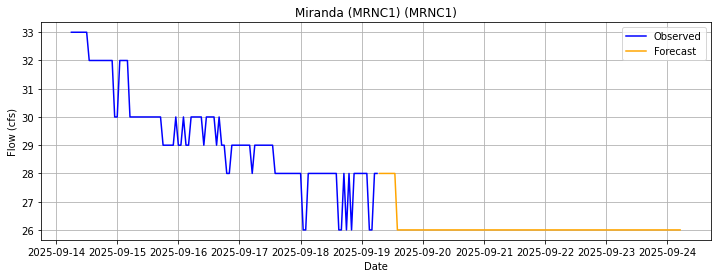

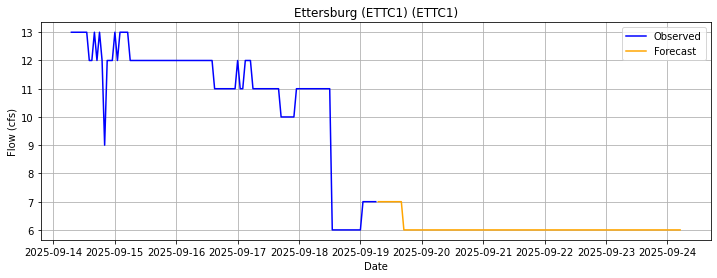

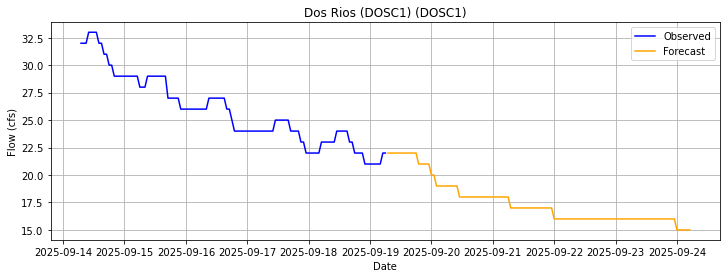

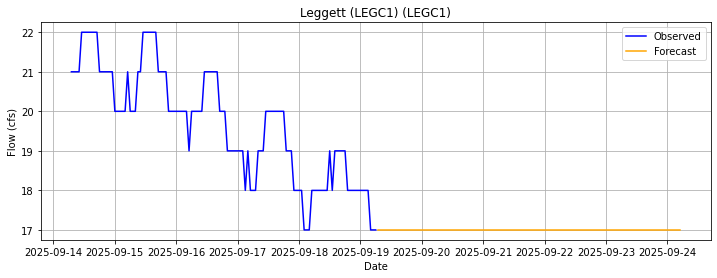

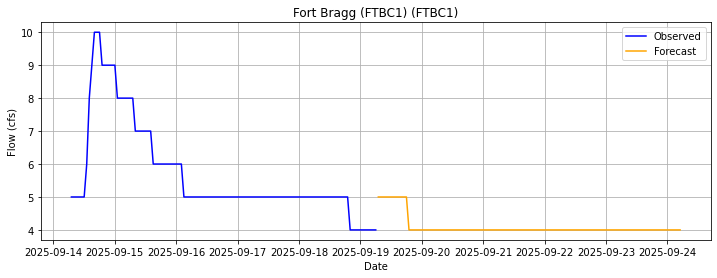

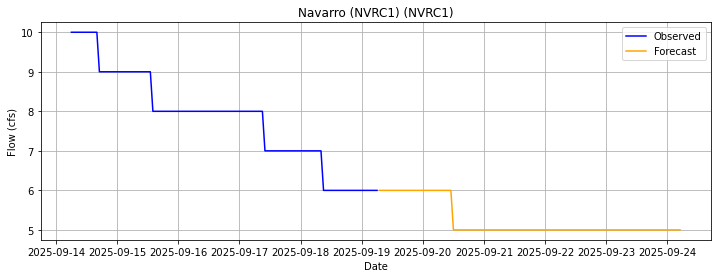

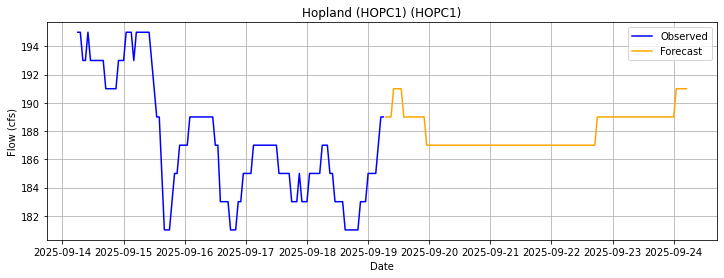

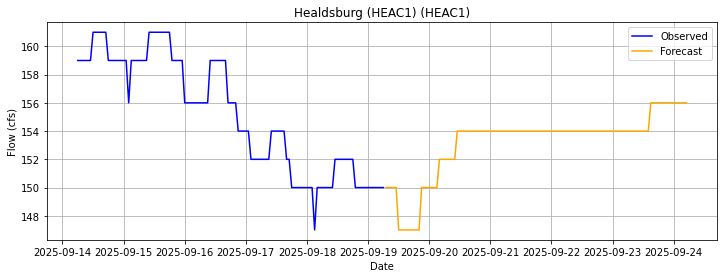

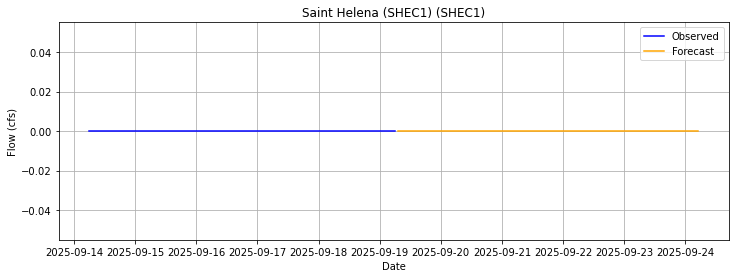

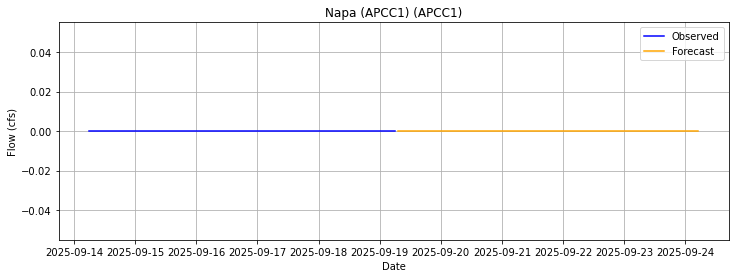

In [85]:
# -------------------
# Plot observed vs forecast for selected sites
# -------------------
def plot_rfc_all_timeseries(rfc_data, gdf_ref, sites_to_plot):
    for nws_id in sites_to_plot:
        if nws_id not in rfc_data:
            print(f"No RFC data for {nws_id}")
            continue
        df_obs = rfc_data[nws_id]["observed"]
        df_fc = rfc_data[nws_id]["forecast"]
        station_name = gdf_ref.loc[gdf_ref["id"] == nws_id, "stationName"].values[0]

        plt.figure(figsize=(12, 4))
        plt.plot(df_obs.index, df_obs["Flow_cfs"], label="Observed", color="blue")
        plt.plot(df_fc.index, df_fc["Flow_cfs"], label="Forecast", color="orange")
        plt.xlabel("Date")
        plt.ylabel("Flow (cfs)")
        plt.title(f"{station_name} ({nws_id})")
        plt.legend()
        plt.grid(True)
        plt.show()

# Example: plot first 10 available sites
sites_to_plot = list(rfc_data_all.keys())[:10]
plot_rfc_all_timeseries(rfc_data_all, gdf_rfc, sites_to_plot)
